In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path

In [9]:
import shutil, tarfile, os, shutil, re
from os.path import basename, isfile
from urllib.parse import urlparse
from urllib.request import urlopen
from pathlib import Path

# Fetch a file from uri, unzip and untar it into its own directory.
def fetch_and_untar(uri):
    # Parse the uri to extract the local filename
    parsed_uri = urlparse(uri)
    local_filename = basename(parsed_uri.path)

    # If file is not already on disk, retrieve from uri
    if not isfile(local_filename):
        with urlopen(uri) as response:
            with open(local_filename, 'bw+') as f:
                shutil.copyfileobj(response, f)

    # Expand the archive
    with tarfile.open(local_filename) as tar:
        tar.extractall()

In [8]:
def move_images_into_labelled_directories(image_dir):
    images_path = Path(image_dir)
    extract_breed_from_filename = re.compile(r'([^/]+)_\d+.jpg$')

    for filename in os.listdir(image_dir):
        match = extract_breed_from_filename.match(filename)
        if match is not None:
            breed = match.group(1)
            if not os.path.exists(images_path / breed):
                os.makedirs(images_path / breed)
            src_path = images_path / filename
            dest_path = images_path / breed / filename
            shutil.move(src_path, dest_path)

In [31]:
path = os.path.join(os.getcwd(), 'images')

fetch_and_untar('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz')
move_images_into_labelled_directories(path)

In [32]:
# Split into training and validation folders
import random 

for subdir, dirs, files in os.walk(path):
    if subdir == path:
        if not os.path.exists(os.path.join(path, 'val')):
            os.mkdir(os.path.join(path, 'val'))

        if not os.path.exists(os.path.join(path, 'train')):
            os.mkdir(os.path.join(path, 'train'))
        continue
    for x in range(40):
        fil = random.choice(os.listdir(subdir))
        os.replace(os.path.join(subdir, fil), os.path.join(path, os.path.join('val', fil)))

    new_dir = os.path.join(os.path.split(subdir)[0], os.path.join('train', os.path.split(subdir)[1]))
    shutil.move(subdir, new_dir)

move_images_into_labelled_directories(os.path.join(os.getcwd(), os.path.join('images', 'val')))

In [86]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
#Save the classes
classes = image_datasets['val'].classes

with open("labels.txt", "w") as output:
    for row in classes:
        output.write(str(row).replace('_', ' ').title() + '\n')

In [87]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [49]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [88]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 37)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [89]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.9751 Acc: 0.4374
val Loss: 0.6725 Acc: 0.7946

Epoch 1/19
----------
train Loss: 1.5152 Acc: 0.5580
val Loss: 0.5904 Acc: 0.8270

Epoch 2/19
----------
train Loss: 1.4105 Acc: 0.6005
val Loss: 0.6354 Acc: 0.8155

Epoch 3/19
----------
train Loss: 1.2966 Acc: 0.6306
val Loss: 0.4983 Acc: 0.8486

Epoch 4/19
----------
train Loss: 1.2161 Acc: 0.6426
val Loss: 0.6197 Acc: 0.8378

Epoch 5/19
----------
train Loss: 1.1615 Acc: 0.6672
val Loss: 0.5144 Acc: 0.8439

Epoch 6/19
----------
train Loss: 1.1340 Acc: 0.6717
val Loss: 0.5377 Acc: 0.8547

Epoch 7/19
----------
train Loss: 0.8509 Acc: 0.7555
val Loss: 0.3332 Acc: 0.9061

Epoch 8/19
----------
train Loss: 0.7649 Acc: 0.7795
val Loss: 0.3055 Acc: 0.9142

Epoch 9/19
----------
train Loss: 0.7175 Acc: 0.7948
val Loss: 0.3110 Acc: 0.9068

Epoch 10/19
----------
train Loss: 0.7261 Acc: 0.7887
val Loss: 0.2957 Acc: 0.9061

Epoch 11/19
----------
train Loss: 0.6874 Acc: 0.8024
val Loss: 0.3139 Acc: 0.9047

Ep

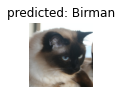

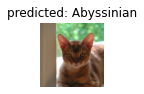

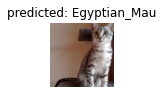

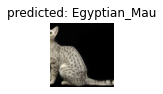

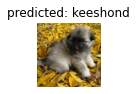

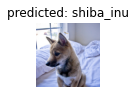

In [50]:
visualize_model(model_ft)

# Save the model

In [59]:
if not os.path.exists(os.path.join(os.getcwd(), 'model')):
    os.mkdir(os.path.join(os.getcwd(), 'model'))

save_dir = os.path.join(os.getcwd(), os.path.join('model', 'checkpoint.pth'))

torch.save(model_ft, save_dir)

# Load Model And Do Inferencing

In [1]:
model = torch.load(save_dir)
model.eval()
# Set it to evaluation mode

NameError: name 'torch' is not defined

In [78]:
from PIL import Image
import requests
from io import BytesIO
from torch.autograd import Variable

imsize = 224
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(url, gpu=False):
    """load image, returns cuda tensor"""
    response = requests.get(url)

    image = Image.open(BytesIO(response.content))
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    if gpu:
        return image.cuda()
    return image 

In [84]:
with open('labels.txt', 'r') as f:
    classes = f.read().splitlines() 

In [83]:
image_url = 'https://cdn1-www.dogtime.com/assets/uploads/2011/01/file_23012_beagle-460x290.jpg'
image = image_loader(image_url, gpu=True)

output = model(image)
index = output.data.cpu().numpy().argmax()
print("The prediction for the image is", classes[index])

The prediction for the image is beagle


# Steps to deploy to Azure

- Deploy the model/checkpoint.pth file to Azure storage in a container named "petdetector"
- Deploy the inference folder to Azure Functions
- Get the connection string for Azure storage and add it as an environment variable for Azure Functions
- Deploy the website/ folder to Azure App Service, with a Python host, and setting the startup command to be "python -m http.server"
- Force your Azure Function to use https
- Enable CORs for the Azure Function